## Edge Style Transfer

In [1]:
import glob
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

(1200, 1600, 3)


Text(0.5,1,'Style Image')

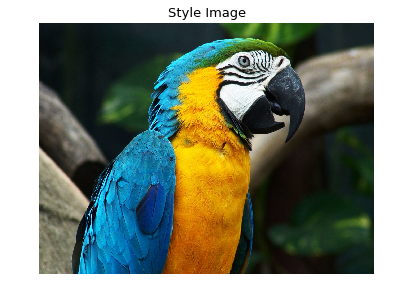

In [2]:
style_img = Image.open('images/bird.jpg')
style_img = np.array(style_img)
print(style_img.shape)
plt.figure(figsize=(6,6))
plt.imshow(style_img)
plt.axis('off')
plt.title('Style Image', fontsize=13)

In [3]:
style_img_pixels = style_img.reshape((style_img.shape[0] * style_img.shape[1], 3))
print(style_img_pixels.shape)
style_img_pixels

(1920000, 3)


array([[15, 26, 30],
       [15, 26, 30],
       [15, 24, 29],
       ...,
       [ 8, 25,  9],
       [ 9, 23,  8],
       [ 9, 23,  6]], dtype=uint8)

In [4]:
np.random.shuffle(style_img_pixels)
style_img_pixels_small = style_img_pixels[:10000]
print(style_img_pixels_small.shape)
style_img_pixels_small

(10000, 3)


array([[ 13,  12,  18],
       [ 13,  26,  16],
       [ 16, 200, 234],
       ...,
       [ 32, 151, 191],
       [177,  87,  11],
       [ 22, 137, 164]], dtype=uint8)

In [5]:
trace1 = go.Scatter3d(
    x=style_img_pixels_small[:,0],
    y=style_img_pixels_small[:,1],
    z=style_img_pixels_small[:,2],
    mode='markers',
    marker=dict(
        size=2,
        color=style_img_pixels_small,
        opacity=0.7
    )
)

data = [trace1]
layout = go.Layout(
    title='RGB Values of Style Image Pixels',
    margin=dict(l=0,r=0,b=0,t=80),
    scene={
        'xaxis': {'title': 'R'},
        'yaxis': {'title': 'G'},
        'zaxis': {'title': 'B'}
    }
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [6]:
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=0)
kmeans.fit(style_img_pixels_small)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [7]:
kmeans.cluster_centers_

array([[ 18.54120267,  27.94365256,  22.15790646],
       [210.30091185, 214.13677812, 206.86322188],
       [132.49544325, 130.93454847, 111.34051367],
       [234.31499312, 173.00137552,   7.80467675],
       [ 27.52027027, 156.59189189, 198.7472973 ],
       [ 57.91833189,  76.15551694,  45.46915725],
       [179.04267425,  97.98008535,   4.15931721],
       [  9.1179173 ,  79.93721286, 129.12404288]])

In [8]:
np.random.seed(0)

color_palette_colors_indices = []
available_colors_indices = list(np.arange(kmeans.cluster_centers_.shape[0]))

# first color in palette is chosen randomly
first_color_index = np.random.choice(available_colors_indices)
color_palette_colors_indices.append(first_color_index)
available_colors_indices.remove(first_color_index)

while len(available_colors_indices) > 0:
    last_color_in_palette_index = color_palette_colors_indices[-1]
    last_color_in_palette = kmeans.cluster_centers_[last_color_in_palette_index]
    distance_to_cluster_centers = np.sqrt(((last_color_in_palette - kmeans.cluster_centers_) ** 2).sum(axis=1))
    color_indices_sorted_by_dist_to_last_color = np.argsort(distance_to_cluster_centers)
    color_indices_sorted_by_dist_to_last_color = [index for index in color_indices_sorted_by_dist_to_last_color 
                                                  if index in available_colors_indices]
    nearest_color_index_to_last_color_in_palette = color_indices_sorted_by_dist_to_last_color[0]
    color_palette_colors_indices.append(nearest_color_index_to_last_color_in_palette)
    available_colors_indices.remove(nearest_color_index_to_last_color_in_palette)

# remove darkest (i.e. black) color
darkest_color_index = np.argmin(kmeans.cluster_centers_.sum(axis=1))
color_palette_colors_indices.remove(darkest_color_index)

color_palette_colors_indices

[4, 7, 5, 6, 3, 2, 1]

In [9]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_to_size = dict(sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True))
cluster_to_size.pop(darkest_color_index)
total_count = sum(cluster_to_size.values())
cluster_to_size = {color_index: count/total_count for (color_index, count) in cluster_to_size.items()}
cluster_to_size

{1: 0.05972045743329098,
 2: 0.21909602468687603,
 3: 0.13196587402432383,
 4: 0.13432564893810128,
 5: 0.20874931929569795,
 6: 0.12760936649119622,
 7: 0.1185333091305137}

(-0.5, 696.5, 49.5, -0.5)

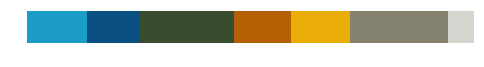

In [10]:
plt.figure(figsize=(8,8))
color_map_length = 100 * len(color_palette_colors_indices)
color_palette = []
for color_index in color_palette_colors_indices:
    color_rgb = kmeans.cluster_centers_[color_index]
    color_bar_length = cluster_to_size[color_index]
    color_bar = np.zeros((50, int(color_bar_length * color_map_length), 3))
    color_bar[:] = color_rgb / 255.0
    color_palette.append(color_bar)
plt.imshow(np.hstack(color_palette))
# plt.title('Color Map Learned from Style Image', fontsize=13)
plt.axis("off")

In [11]:
def convolution(img, kernel):
    """Returns the convolution of img with kernel."""
    
    img_shape = img.shape
    result = np.zeros(img_shape)
    kernel_size = kernel.shape[0]
    pad_size = int((kernel_size - 1) / 2)
    img = np.pad(img, (pad_size, pad_size), "edge")   # padding to match kernel size
    for i in range(0, img_shape[0]):
        for j in range(0, img_shape[1]):
            val = np.sum(img[i:i + kernel_size, j:j + kernel_size] * kernel)
            result[i, j] = val
    return result

def edge_detection(img):
    """Returns the magnitude and direction of the edges in img"""
    
    sobel_filter_horizontal = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_filter_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_x = convolution(img, sobel_filter_horizontal)
    img_gradient_y = convolution(img, sobel_filter_vertical)
    img_gradient_magnitude = ((img_gradient_x ** 2) + (img_gradient_y ** 2)) ** (1/2)
    img_gradient_direction = np.arctan2(img_gradient_x, img_gradient_y)
    return img_gradient_x, img_gradient_y, img_gradient_magnitude, img_gradient_direction

def color_map(color_palette_colors_indices, color_palette_colors, cluster_to_size, direction):
    total_dir = 0
    for color_index in color_palette_colors_indices:
        direction_covered_by_color = cluster_to_size[color_index]
        total_dir += direction_covered_by_color
        if direction < total_dir:
            break
    return color_palette_colors[color_index] / 255

def edge_color(img_edge_magnitude, img_edge_direction, 
               color_palette_colors_indices, color_palette_colors, cluster_to_size):
    """Colors the edges of the image using their direction and a colormap."""
    
    img_shape = img_edge_magnitude.shape
    img_edge_direction = img_edge_direction + abs(img_edge_direction.min())
    img_edge_direction_max = img_edge_direction.max()
#     color_range = plt.cm.get_cmap(cmap)
#     print(color_range)
    black_pixel = np.array([0, 0, 0])
    result = np.zeros((img_shape[0], img_shape[1], 3))
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if img_edge_magnitude[i, j] == 1:
                # if edge is present, select a color based on the edge direction
                color_dir = img_edge_direction[i, j] / img_edge_direction_max
                color = color_map(color_palette_colors_indices, color_palette_colors, cluster_to_size, color_dir)
                result[i, j] = color
            else:   # if edge is not present, just add a black pixel
                result[i, j] = black_pixel
    return result

Text(0.5,1,'Content Image')

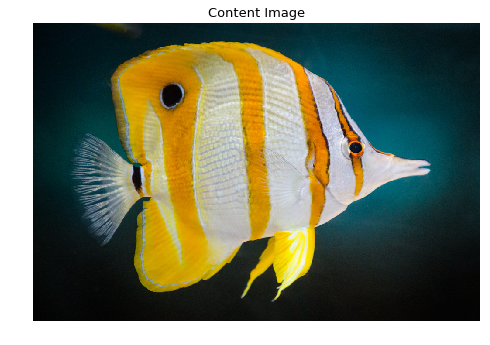

In [12]:
img = Image.open("images/fish.jpg")
img = np.array(img)
img = img/255
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img)
plt.title("Content Image", fontsize=13)

(-0.5, 1023.5, 682.5, -0.5)

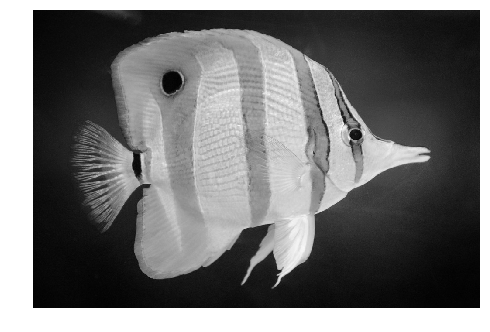

In [13]:
img = Image.open("images/fish.jpg")
img = img.convert("L")   # convert to grayscale
img = np.array(img)
img = img/255
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.axis("off")

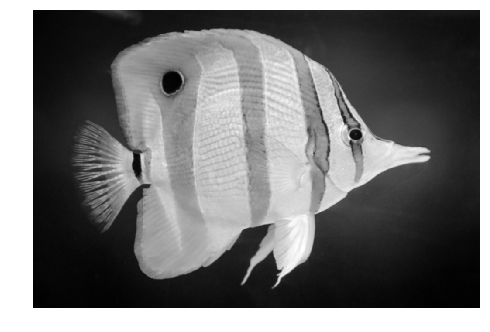

In [18]:
blur_filter = 1/9 * np.ones([3, 3])
img_blurred = convolution(img, blur_filter)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img_blurred, cmap="gray")

In [19]:
img_gradient_x, img_gradient_y, img_edge_magnitude, img_edge_direction = edge_detection(img_blurred)

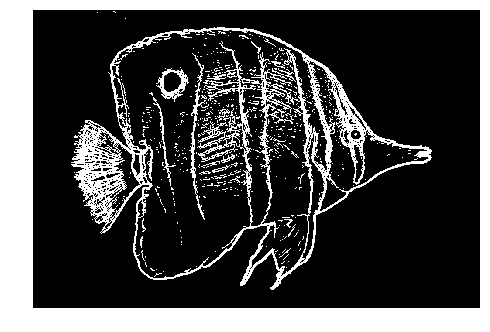

In [24]:
threshold = 0.15
img_edge_magnitude_thresholded = (img_edge_magnitude > threshold)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img_edge_magnitude_thresholded, cmap="gray")

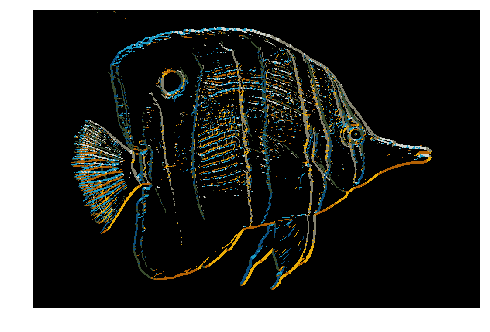

In [25]:
img_edge_colored = edge_color(img_edge_magnitude_thresholded, img_edge_direction, 
                              color_palette_colors_indices, kmeans.cluster_centers_, cluster_to_size)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(img_edge_colored)
img_edge_colored = Image.fromarray((img_edge_colored * 255).astype('uint8'))
img_edge_colored.save('results/fish_colored.png')